<h1><center>Introduction to quantum science and technology - QUANT 400</center></h1>

<p><center> <b>Lecturer:</b> <i>Prof. G. Carleo</i> </center><p>
    
<p><center> <b>Assistant: </b> <i>friederike.metz@epfl.ch

## Exercise 1 - Quantum spin models

### Exact diagonalization of the transverse field Ising Hamiltonian

Our goal in the first part of this exercise is to compute the ground state of the transverse field Ising Hamiltonian

$$\hat H_{\text{Ising}} = J \sum_{i=1}^N \hat \sigma_i^z \hat \sigma_{i+1}^z - \Gamma \sum_{i=1}^N \hat \sigma_i^x$$

Let's first import everything we need in the following.

In [1]:
from functools import lru_cache
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_array, identity, kron
from scipy.sparse.linalg import eigsh

Now start by defining the single-spin Pauli operators in a sparse matrix format

In [2]:
# pauli matrices
sx = csr_array([[0, 1], [1, 0]])
sz = csr_array([[1, 0], [0,-1]])

Define a function to generate the many-body operator 
$$\hat{\sigma}_{i}^{\alpha}  = \underbrace{\hat{I}\otimes\hat{I}\otimes\dots\hat{I}}_{i-1\,\mathrm{times}}\otimes\hat{\sigma}^{\alpha}\otimes\underbrace{\hat{I}\otimes\dots\otimes\hat{I}}_{N-i\:\mathrm{times}})$$

We can use `np.kron` to generate the Kronecker product of the 2x2 matrices representing the single-spin operators.

In [3]:
def operator(pauli, i, N):
    left = identity(2**i)
    right = identity(2 ** (N - i - 1))
    mat = kron(kron(left, pauli), right)

    # Explicitly convert to CSR since kron likes to return COO
    mat = csr_array(mat)
    return mat

In [4]:
op = operator(sx, 0, 2)
print(type(op))

<class 'scipy.sparse._csr.csr_array'>


Using sparse matrices for the pauli operators $\hat{\sigma}_{i}^{\alpha}$ defined above we write a function which constructs the transverse field ising hamiltonian 
$$\hat H_{\text{Ising}} = J \sum_{i=1}^N \hat \sigma_i^z \hat \sigma_{i+1}^z - \Gamma \sum_{i=1}^N \hat \sigma_i^x$$

In [5]:
def tfi_hamiltonian(N, J, gamma):
    H = 0
    for i in range(N):
        j = (i+1)%N
        H += J * operator(sz, i, N) @ operator(sz, j, N)
    for i in range(N):
        H -= gamma * operator(sx, i, N)
    return H

We can check that for 2 spins we get the correct matrix:

In [6]:
n_spins = 2
J= 1
gamma = 0.1

print(tfi_hamiltonian(n_spins, J, gamma).todense())

[[ 2.  -0.1 -0.1  0. ]
 [-0.1 -2.   0.  -0.1]
 [-0.1  0.  -2.  -0.1]
 [ 0.  -0.1 -0.1  2. ]]


We can use scipy to diagonalize the hamiltonian using the Lanczos algorithm

In [7]:
n_spins = 10

H = tfi_hamiltonian(n_spins, J, gamma)

# If we set `k=2`, the Lanczos algorithm may not really converge to the two smallest eigenvectors
# From my experience it's safe to set `k` to the double of what we need
E_ed = eigsh(H, k=4, which="SA", return_eigenvectors=False)
print(E_ed)

[ -6.38306387  -6.40332833 -10.02501566 -10.02501566]


However, now let's implement the power method for finding ground states ourselves. Recall that this method generates a sequence of vectors by repeated application of the Hamiltonian

$$ \left|u_{k+1}\right\rangle=(\Lambda \hat{I}-\hat{H})\left|u_k\right\rangle $$

In [8]:
# lambda is a reserved keyword for lambda functions, 
# so we can't give the variable like that name....
def power_method(H, n_spins, n_iters, lambd=1, u0=None):
    if u0 is None:
        # take a random vector as in initial guess
        # TODO this is a real vector but depending on the hamiltonian
        # it might need to be complex
        u = np.random.normal(size=2**n_spins)
    else:
        u = u0
        
    # construct the propagator
    I = csr_array(identity(2**n_spins))
    prop = lambd * I - H

    old = np.inf
    energies = []
    for i in range(n_iters):
        u = prop @ u
        
        # normalize the vector
        # this is necessary since the propagator is not unitary
        # and if we do a lot of iterations the floating point numbers in u  would grow
        # very quickly to the point where the exponent overflows
        # also it is convenient for computing the expectation value below
        u = u / np.linalg.norm(u)
        
        # compute the expectation value
        # For a CSR array `(u @ h) @ u` is slow, therefore we do it the other way round
        e = u.T.conj() @ (H @ u)
    
        # stop early if the energy does not improve anymore
        if np.abs((old - e) / e) < 1e-15:
            break

        energies.append(e)
        old = e

    return u, energies

For the TFI in 1D with periodic boundary conditions we can upper bound the largest eigenvalue $E_M$ with
$$E_M \leq |J| N + |\Gamma| N  $$

and so to satisfy $\Lambda > E_M$ we can choose
$$ \Lambda = |J| N + |\Gamma| N$$


Note that it is also possible to derive a tighter condition for $\Lambda$ than given in the lecture notes _(see Becca & Sorella 2017, pp. 34)_, namely $\Lambda > \frac{E_0 + E_M}{2}$. This means that for the TFI with even $N$ the power method should converge for any $\Lambda > 0$.

In [9]:
lambd = abs(J)*n_spins + abs(gamma)*n_spins

v, E_pwr = power_method(H, n_spins, n_iters=2000, lambd=lambd)
E_pwr[-1]

np.float64(-10.025015664224645)

Check that both the scipy implentation and our own method find the same ground state energy.

In [10]:
np.allclose(E_pwr[-1], E_ed[-1])

True

We see that the power method converges nicely already after a few steps

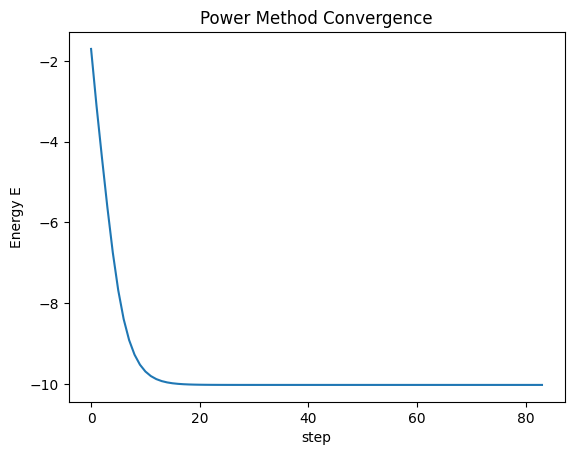

In [11]:
plt.plot(E_pwr)
plt.ylabel("Energy E")
plt.xlabel("step")
plt.title('Power Method Convergence')
plt.show()

We proceed by computing the ground state energy for different system sizes N and transverse field strengths $\Gamma$ and studying the spin-spin correlator
$$C = \langle \psi_0 | \hat \sigma_0^z \hat \sigma_{N/2}^z | {\psi_0} \rangle$$

which measures how correlated a spin is with the one furthest away.

N=6
N=8
N=10
N=12
N=14


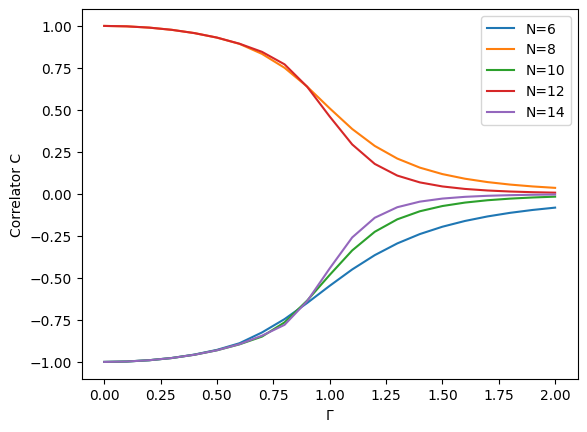

In [12]:
Ns = [6, 8, 10, 12, 14]
gs = np.linspace(0, 2, 21)

corr = np.zeros((len(Ns), len(gs)))

for i, N in enumerate(Ns):
    print(f"N={N}")
    for j, g in enumerate(gs):
        H = tfi_hamiltonian(N, J=1, gamma=g)
        v, e = power_method(H, N, 1000)
        corr[i, j] = v.T.conj() @ (operator(sz, 0, N) @ (operator(sz, N//2, N) @ v))
    plt.plot(gs, corr[i, :], label=f"N={N}")
plt.ylabel("Correlator C")
plt.xlabel(r"$\Gamma$")
plt.legend()
plt.show()

The correlator quickly vanishes for $\Gamma > 1$ and approaches unity for $\Gamma < 1$. For larger system sizes, the curve gets closer and closer to a step function. This is a characteristic of a phase transition.

Next we compute the ground state as well as first excited state energy using ED and plot both to study the energy gap.

In [13]:
Ns = [6, 8, 10, 12, 14]
gs = np.linspace(0, 2, 21)

k = 4  # how many eigenvalues to compute

energies = np.zeros((len(Ns), len(gs), k))

for i, N in enumerate(Ns):
    for j, g in enumerate(gs):
        H = tfi_hamiltonian(N, J=1, gamma=g)
        # we sort the energies in increasing order, 
        # so that energies[:, :, 0] is the ground state energy
        energies[i, j, :] = np.sort(eigsh(H, k=k, which="SA", return_eigenvectors=False))

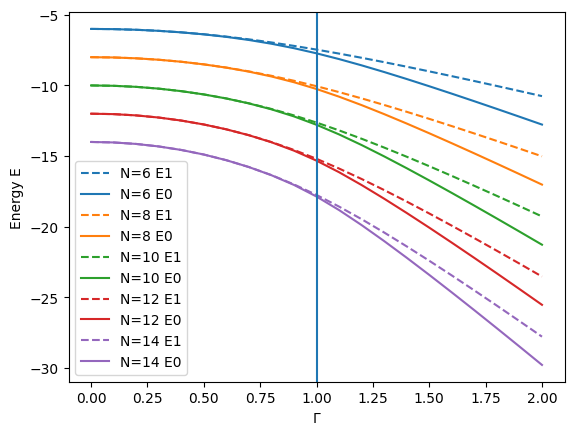

In [14]:
for i, N in enumerate(Ns):
    plt.plot(gs, energies[i, :, 1], label=f"N={N} E1", color=f"C{i}", linestyle="--")
    plt.plot(gs, energies[i, :, 0], label=f"N={N} E0", color=f"C{i}")

plt.axvline((1.0))
plt.ylabel("Energy E")
plt.xlabel(r"$\Gamma$")
plt.legend()
plt.show()

We see that the energy gap between the ground and first excited state seems to vanish at the critical point for increasing system sizes. Let's study this feature of criticality, i.e., the "closing of the gap" more systematically. To that end we plot the gap at the critical point $\Gamma/J = 1$ for different system sizes and extrapolate to $N \to \infty$ (thermodynamic limit).

Γ = 1.0
slope: 1.00548
Energy gap at 1/N -> 0: 0.00000


/var/folders/g2/zp6r_4wd2jbb_yn3bzh8tqjh0000gq/T/ipykernel_34081/3765796787.py:9: RuntimeWarning: divide by zero encountered in log
  f = lambda x: np.exp(a[0]*np.log(x)+a[1])


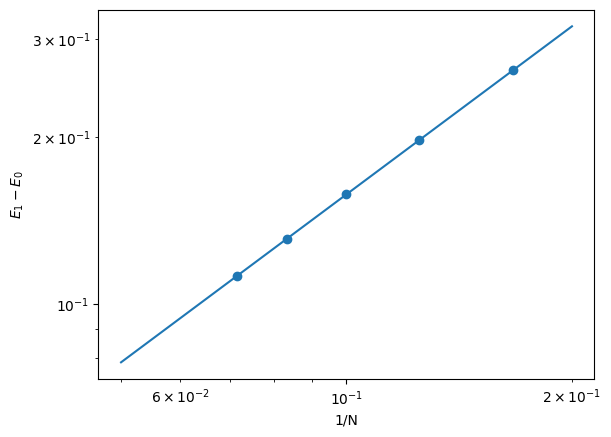

In [15]:
i = len(gs)//2
print(f'Γ = {gs[i]}')
gap = energies[:, i, 1] - energies[:, i, 0]

Ninv = 1 / np.array(Ns)

# fit
a = np.polyfit(np.log(Ninv), np.log(gap), 1)
f = lambda x: x**a[0] * np.exp(a[1])

print(f'slope: {a[0]:0.5f}')
print(f"Energy gap at 1/N -> 0: {f(1/np.inf):0.5f}")


plt.scatter(Ninv, gap)
x = np.linspace(0.05, 0.2, 100)
plt.plot(x, f(x))
plt.xscale('log')
plt.yscale('log')

plt.xlabel('1/N')
plt.ylabel('$E_1-E_0$')
plt.show()

Indeed the energy gap vanishes in the thermodynamic limit as we would expect for a quantum phase transition.

### Problem 1: Time evolution of the transverse field Ising chain

Having studied the ground state of the Ising model, we now want to consider its dynamics. We will build the code step-by-step in the following.

a) Define a function that takes as an input the number of spins $N$ and the site index $i$ and returns the fowllowing operator in a sparse matrix format:

$$\exp(-i \delta \hat \sigma_i^x)$$

i.e., the time evolution operator for the transverse field part.

Note that you can use functions that were previously defined in this notebook.

In [12]:
@lru_cache # for speedup
def exp_x(N, i, delta):
    I = identity(2**N)
    Xi = operator(sx, i, N)
    
    mat = np.cos(delta) * I - 1j * np.sin(delta) * Xi
    
    mat = csr_array(mat)
    return mat

b) Similarly, define the time evolution operator for the diagonal part, i.e.,
$$\exp(-i \delta \hat \sigma_i^z \sigma_{i+1}^z)  $$

In [13]:
@lru_cache # for speedup
def exp_zz(N, i, delta):
    Zi = operator(sz, i, N)
    # here we write the code for periodic boundary conditions, 
    # for open boundary conditions we assume i only goes to N-2
    Zi_p_1 = operator(sz, (i+1)%N, N)
    I = identity(2**N)
    
    mat = np.cos(delta) * I - 1j * np.sin(delta) * Zi@Zi_p_1
    
    mat = csr_array(mat)
    return mat

c) Putting everything together define a function which performs the time evolution

$$ \exp (-i \hat{H} t) \approx \exp(-i \frac{\Delta_t}{2}  \hat H_\mathrm{Z Z}) \ldots \exp(-i \Delta_t \hat H_\mathrm{X})   \exp(-i \Delta_t \hat H_\mathrm{Z Z}) \ldots \exp(-i \Delta_t \hat H_\mathrm{X}) \exp(-i \frac{\Delta_t}{2}  \hat H_\mathrm{Z Z}) $$

i.e., using the 2nd order Suzuki-Trotter decomposition

In [242]:
def time_evol(psi, t, dt, J, gamma):
    n_steps = round(t / dt) # number of Suzuki-Trotter steps
    
    for i in range(N): # N-1 because we assume obc
        psi = exp_zz(N, i, J*dt/2) @ psi
        
    for i in range(N):
        psi = exp_x(N, i, -gamma*dt) @ psi
        
    for step in range(n_steps-1):

        for i in range(N):
            # here we fuse the two exp_Hzz(N, i, dt/2) of two 
            # consecutive steps into one exp_Hzz(N, i, dt)
            psi = exp_zz(N, i, J*dt) @ psi
            
        for i in range(N):
            psi = exp_x(N, i, -gamma*dt) @ psi
            
    for i in range(N):
        psi = exp_zz(N, i, J*dt/2) @ psi
        
    return psi

In [261]:
def time_evol_slow(psi, t, dt, J, gamma):
    n_steps = round(t / dt) # number of Suzuki-Trotter steps

    exps_x = exp_x(N, 0, -gamma*dt)
    exps_zz = exp_zz(N, 0, J*dt/2)
    
    for i in range(1,N): # N-1 because we assume obc
        exps_x = exp_x(N, i, -gamma*dt) @ exps_x
        exps_zz = exp_zz(N, i, J*dt/2) @ exps_zz
        
    exp_delta = exps_zz @ exps_x @ exps_zz
            
    for step in range(n_steps):
        psi = exp_delta @ psi
        
    return psi

In [254]:
%timeit time_evol(psi.copy(), 1.0, 1e-2, J, gamma)

23.7 ms ± 705 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [262]:
%timeit time_evol_slow(psi.copy(), 1.0, 1e-2, J, gamma)

116 ms ± 968 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


During the time evolution we want to measure the $\langle \sigma_i^z \rangle$ magnetization at each site.

d) Define a function that takes as an input a quantum state `psi` and a list of `observables` to measure. It should then return a list of expectations values of the corresponding observables on the quantum state `psi`

In [239]:
def measure(psi, observalbes):
    return [((psi.conj().T @ O) @ psi) for O in observalbes]

e) Starting with an initial state with all-down configuration and $N=10$ spins

$$|\Psi\rangle = |\downarrow\rangle \otimes |\downarrow\rangle \otimes \ldots \otimes |\downarrow\rangle$$

In [263]:
spin_up = np.array([1, 0])
spin_down = np.array([0, 1])

N = 10

psi = 1
for i in range(N):
    psi = np.kron(psi, spin_down)

run the time evolution for $J=0, \Gamma=1$ and measure the magnetization $\langle \sigma_i^z \rangle$ at each site i during the evolution

In [264]:
dt = 1e-2 # Trotter time step size (Delta t)
t = 10 # total evolution time
n_points = 100
ts = np.linspace(0, t, n_points+1) # measure the magnetization at these times

J = 0.
gamma = 1.

psi_t = psi.copy()

observables = [operator(sz, i, N) for i in range(N)]
magnetization = []

magnetization.append(measure(psi, observables))
for i in range(1, n_points+1):
    psi_t = time_evol(psi_t, t/n_points, dt, J, gamma)
    magnetization.append(measure(psi_t, observables))

and plot the magnetization $\langle \sigma_i^z \rangle$ over time for each site i

In [265]:
magnetization = np.array(magnetization).real.T

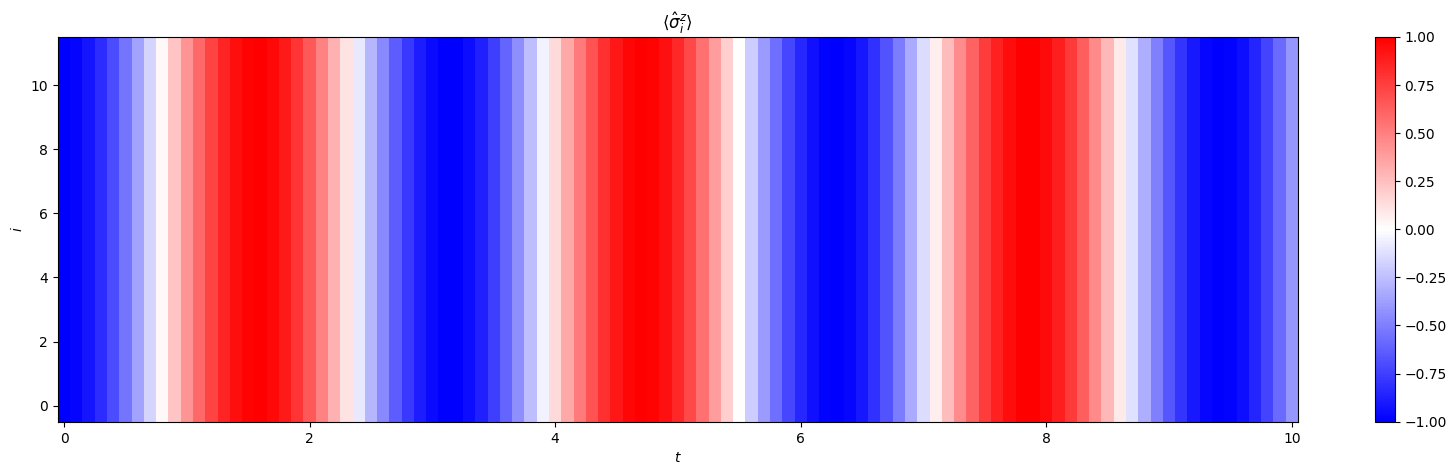

In [266]:
plt.figure(figsize=(20, 5))
plt.pcolormesh(ts, range(N), magnetization, cmap="bwr", vmin=-1, vmax=1, shading="nearest")
plt.xlabel("$t$")
plt.ylabel("$i$")
plt.title(r"$\langle \hat \sigma^z_i \rangle$")
plt.colorbar()
plt.show()

The dynamics is rather boring as the spins do not interact with each other and are fully decoupled.

f) Do the same as in e) but for an initial state with all spins down except one spin up in the middle

$$|\Psi\rangle = |\downarrow\rangle \otimes \ldots \otimes |\uparrow\rangle \otimes \ldots \otimes |\downarrow\rangle$$


and $J=1, \Gamma=0.4$. (Now we let the spins interact.)

In [267]:
# Initial state 

psi = 1
for i in range((N - 1) // 2):
    psi = np.kron(psi, spin_down)
psi = np.kron(psi, spin_up)
for i in range(N // 2):
    psi = np.kron(psi, spin_down)

In [268]:
J = 1
gamma = 0.4 

dt = 2e-1
t = 40
n_points = 100
ts = np.linspace(0, t, n_points+1)

psi_t = psi.copy()

magnetization, psis = [], []

psis.append(psi_t.copy())
magnetization.append(measure(psi, observables))
for i in range(1, n_points+1):
    psi_t = time_evol(psi_t, t/n_points, dt, J, gamma)
    psis.append(psi_t.copy())
    magnetization.append(measure(psi_t, observables))

magnetization = np.array(magnetization).real.T
psis = np.array(psis)

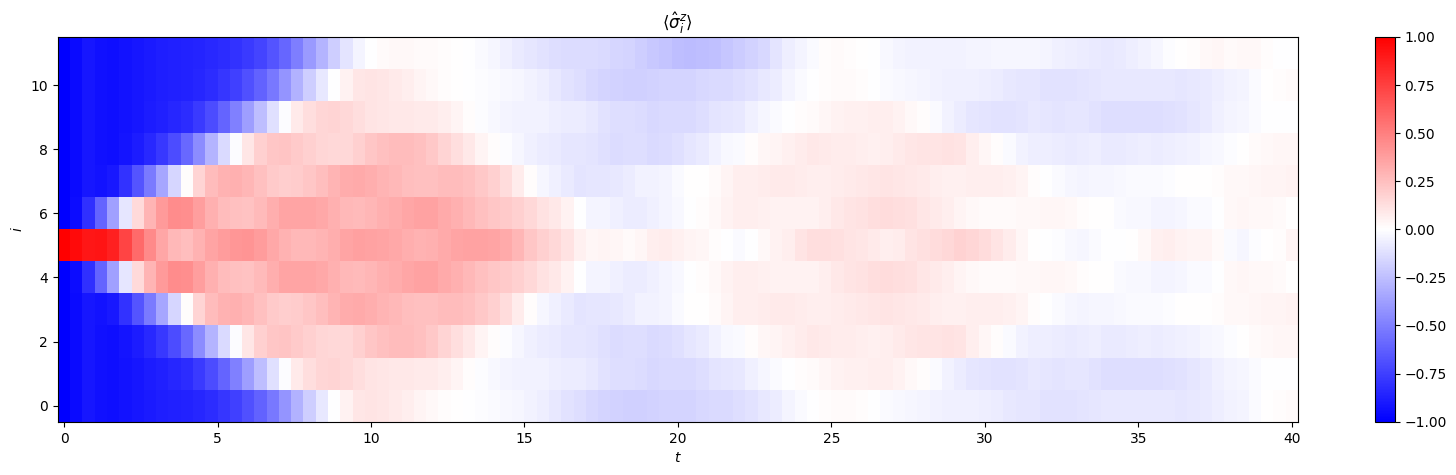

In [269]:
plt.figure(figsize=(20, 5))
plt.pcolormesh(ts, range(N), magnetization, cmap="bwr", vmin=-1, vmax=1, shading="nearest")
plt.xlabel("$t$")
plt.ylabel("$i$")
plt.title(r"$\langle \hat \sigma^z_i \rangle$")
plt.colorbar()
plt.show()

g) Let's compare this result to an exact simulation not based on the Trotter approximation.

In [270]:
from scipy.sparse.linalg import expm

psi_t = psi.copy()

H = tfi_hamiltonian(N, J, gamma)
evolv_u = expm(-1j * H * ts[1]) # this computes the matrix exponential of the full Hamiltonian

magnetization_exact, psis_exact = [], []

psis_exact.append(psi)
magnetization_exact.append(measure(psi, observables))
for i in range(1, n_points+1):
    psi_t = evolv_u @ psi_t
    psis_exact.append(psi_t.copy())
    magnetization_exact.append(measure(psi_t, observables))
    
magnetization_exact = np.array(magnetization_exact).real.T
psis_exact = np.array(psis_exact)

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.11/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


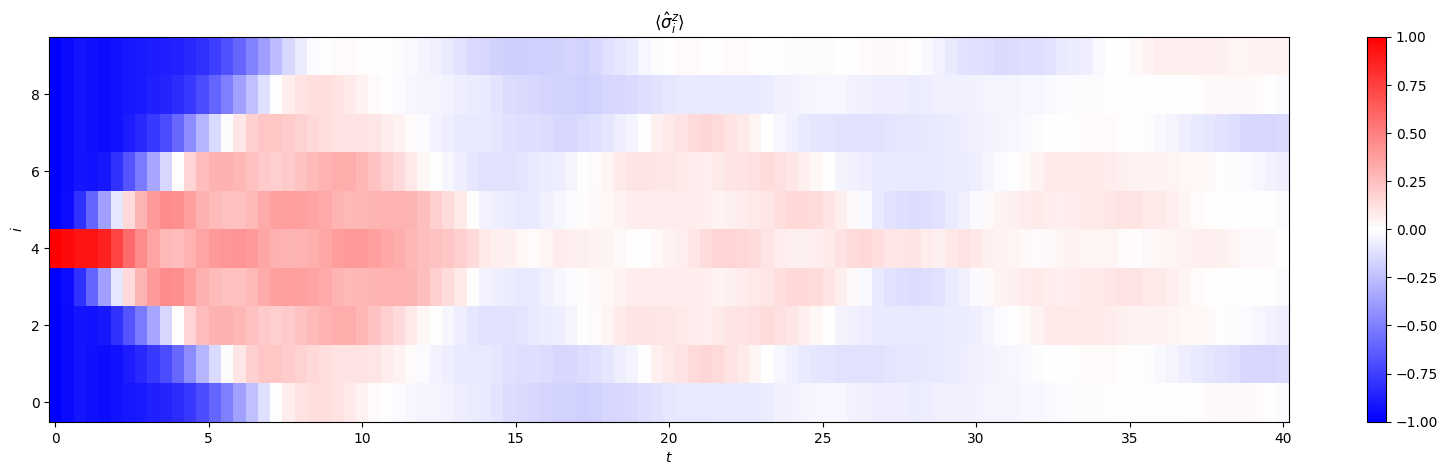

In [222]:
plt.figure(figsize=(20, 5))
plt.pcolormesh(ts, range(N), magnetization_exact, cmap="bwr", vmin=-1, vmax=1, shading="nearest")
plt.xlabel("$t$")
plt.ylabel("$i$")
plt.title(r"$\langle \hat \sigma^z_i \rangle$")
plt.colorbar()
plt.show()

h) The magnetizations computed using the exact and trotterized evolution method start deviating at longer times. How can you make the trotterized time evolution more exact also at large times? Try it out!

To see more clearly how the exact time evolved and the trotterized time evolved quantum state deviate, we compute the fidelity between the two states. The fidelity is nothing but the absolute value of the inner product between the states:

$$ F(t) = |\langle \Psi_{exact}(t)|\Psi_{trotter}(t) \rangle| .$$

The fidelity is 1 if and only if the states are exactly the same. Otherwise, the fidelity is smaller than 1. If the states are orthogonal, the fidelity would be 0.

In [223]:
fidelity = np.abs(np.matmul(psis.conj().reshape(-1, 1, 2**N), psis_exact.reshape(-1, 2**N, 1))).reshape(-1)

Below we plot the infidelity $1-F$ which is zero if the states are the same, and 1 if they are orthogonal. Plotting the infidelity allows us to use a log-scale.

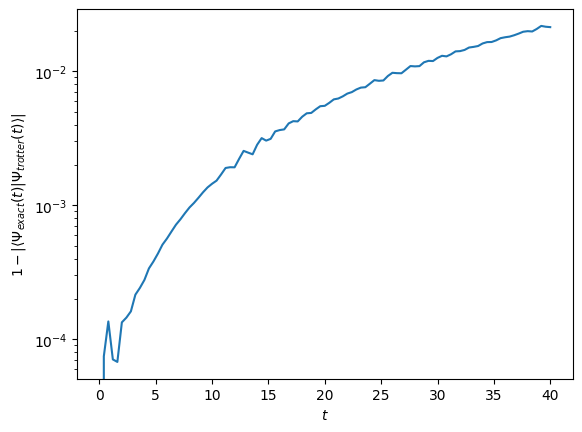

In [224]:
plt.plot(ts, 1-fidelity)
plt.yscale('log')
plt.ylabel(r"$1-|\langle \Psi_{exact}(t)|\Psi_{trotter}(t) \rangle|$")
plt.xlabel("$t$")
plt.show()

We now see that the infidelity increases (the fidelity decreases) as time progresses. Hence, the Trotter approximation becomes less and less accurate the longer we evolve, as errors accumulate over time. This effect is enhanced if you choose $\Gamma \sim 1$ close to the critical point. We can reduce the Trotter error by choosing a smaller time step size $\Delta_t$ or by performing a higher order Trotter decomposition. 

# ❗️ Preparation for next exercise class

__Option A:__
* On noto open a bash console
* Run the following commands one after another
    1. `my_venvs_create quant`
    2. `my_venvs_activate quant`
    3. `pip install qiskit[visualization]`
    4. `my_kernels_create quant "QUANT400"`

__Option B:__
* If you use jupyter notebooks locally, install the latest, stable version of [qiskit](https://docs.quantum.ibm.com/guides/install-qiskit).